随机抽取数据

In [16]:
checkin_sample = checkin_df.sample(n=8000, random_state=42)  # 设置随机种子以保证复现

In [17]:
# Step 1: 为节点添加特征
for node in graph.nodes:
    graph.nodes[node]["features"] = [graph.degree[node]]

# 添加签到特征
checkin_features = checkin_sample.groupby("user").agg(
    checkin_count=("location_id", "count"),
    unique_locations=("location_id", "nunique")
).reset_index()

checkin_features["checkin_count"] = (checkin_features["checkin_count"] - checkin_features["checkin_count"].mean()) / checkin_features["checkin_count"].std()
checkin_features["unique_locations"] = (checkin_features["unique_locations"] - checkin_features["unique_locations"].mean()) / checkin_features["unique_locations"].std()

for _, row in checkin_features.iterrows():
    if row["user"] in graph.nodes:
        graph.nodes[row["user"]]["features"] = [row["checkin_count"], row["unique_locations"]]


In [18]:
#增加地理位置特征
from geopy.distance import geodesic # 用于计算地理距离
from collections import Counter

In [19]:
# 默认特征为 [0, 0]
default_feature = [0, 0]

# 为所有节点分配默认特征
for node in graph.nodes:
    if "features" not in graph.nodes[node]:
        graph.nodes[node]["features"] = default_feature
    elif len(graph.nodes[node]["features"]) != len(default_feature):
        # 如果特征长度不为 2，用默认特征替换
        graph.nodes[node]["features"] = default_feature

# 添加签到特征
for _, row in checkin_features.iterrows():
    if row["user"] in graph.nodes:
        graph.nodes[row["user"]]["features"] = [row["checkin_count"], row["unique_locations"]]

In [20]:
# 找出特征长度不为 2 的节点
inconsistent_nodes = [node for node in graph.nodes if len(graph.nodes[node]["features"]) != 2]

# 修复这些节点的特征
for node in inconsistent_nodes:
    print(f"修复前节点 {node} 的特征: {graph.nodes[node]['features']}")
    graph.nodes[node]["features"] = default_feature
    print(f"修复后节点 {node} 的特征: {graph.nodes[node]['features']}")

In [21]:
# 提取 sample 中涉及的用户节点
sample_nodes = checkin_sample['user'].unique()

# 创建包含这些用户的子图
graph_sample = graph.subgraph(sample_nodes)

# 提取子图中的所有真实边
all_edges = list(graph_sample.edges)

# 提取子图中不存在的边（即负样本）
all_non_edges = list(nx.non_edges(graph_sample))

朋友预测

In [22]:
# Split edges into train/test
train_edges, test_edges = train_test_split(all_edges, test_size=0.2, random_state=42)
train_non_edges, test_non_edges = train_test_split(all_non_edges, test_size=0.2, random_state=42)


In [23]:
# Combine edges and non-edges for training and testing
train_samples = train_edges + train_non_edges
train_labels = [1] * len(train_edges) + [0] * len(train_non_edges)
test_samples = test_edges + test_non_edges
test_labels = [1] * len(test_edges) + [0] * len(test_non_edges)

In [24]:
def generate_edge_features(graph, edge_list):
    features = []
    for u, v in edge_list:
        # 获取节点特征，确保使用默认特征作为兜底
        u_features = np.array(graph.nodes[u].get("features", [0, 0]))
        v_features = np.array(graph.nodes[v].get("features", [0, 0]))
        # 计算特征差值
        feature_diff = np.abs(u_features - v_features)
        features.append(feature_diff)
    return np.array(features)


In [25]:
# 使用签到数据扩展特征
for _, row in checkin_features.iterrows():
    if row["user"] in graph.nodes:
        graph.nodes[row["user"]]["features"] = [row["checkin_count"], row["unique_locations"]]
    else:
        graph.nodes[row["user"]]["features"] = [0, 0]  # 默认值

# 检查特征长度一致性
feature_lengths = [len(graph.nodes[node]["features"]) for node in graph.nodes if "features" in graph.nodes[node]]
assert len(set(feature_lengths)) == 1, "节点特征长度不一致！"

# 生成边特征
train_features = generate_edge_features(graph, train_samples)
test_features = generate_edge_features(graph, test_samples)


In [26]:
# 转换为 NumPy 数组
train_samples = np.array(train_samples)
train_labels = np.array(train_labels)
test_samples = np.array(test_samples)
test_labels = np.array(test_labels)

In [48]:
#减负，跑不动
sample_indices = np.random.choice(len(train_features), size=5000, replace=False)
train_features_sampled = train_features[sample_indices]
train_labels_sampled = train_labels[sample_indices]

In [27]:
pip install imblearn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
from imblearn.under_sampling import RandomUnderSampler

# 使用欠采样减少多数类样本
rus = RandomUnderSampler(random_state=42)
train_features_balanced, train_labels_balanced = rus.fit_resample(train_features, train_labels)


In [29]:
clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight="balanced",  # 自动调整类别权重
    random_state=42
)

In [30]:
clf.fit(train_features_balanced, train_labels_balanced)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=42)

In [31]:
# Evaluate the classifier
predictions = clf.predict(test_features)
print("Accuracy:", accuracy_score(test_labels, predictions))
print("Classification Report:\n", classification_report(test_labels, predictions))

Accuracy: 0.6060847294539022
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.61      0.75   2360949
           1       0.00      0.68      0.01      4415

    accuracy                           0.61   2365364
   macro avg       0.50      0.64      0.38   2365364
weighted avg       1.00      0.61      0.75   2365364



In [32]:
from sklearn.metrics import roc_auc_score

probs = clf.predict_proba(test_features)[:, 1]
roc_auc = roc_auc_score(test_labels, probs)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.6769713447286656


In [33]:
# 测试模型
predictions = clf.predict(test_features)
probs = clf.predict_proba(test_features)[:, 1]

# 输出评估结果
print("Accuracy:", accuracy_score(test_labels, predictions))
print("Classification Report:\n", classification_report(test_labels, predictions))
print("ROC-AUC Score:", roc_auc_score(test_labels, probs))

Accuracy: 0.6060847294539022
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.61      0.75   2360949
           1       0.00      0.68      0.01      4415

    accuracy                           0.61   2365364
   macro avg       0.50      0.64      0.38   2365364
weighted avg       1.00      0.61      0.75   2365364

ROC-AUC Score: 0.6769713447286656


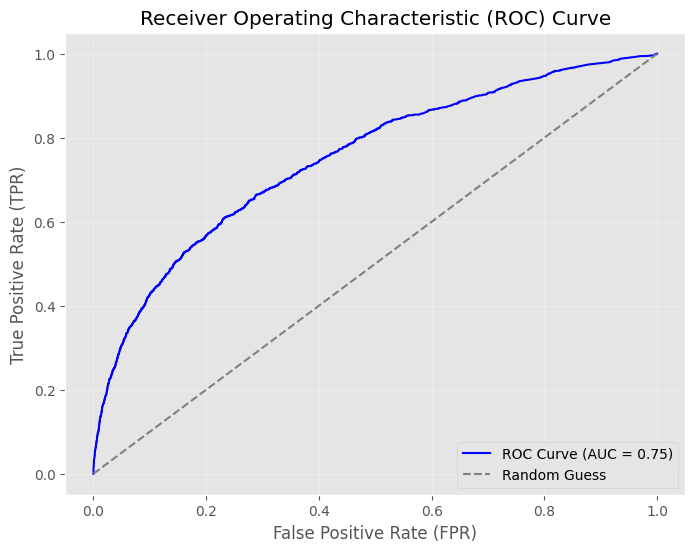

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# 计算预测概率
probs = clf.predict_proba(test_features)[:, 1]  # 获取类别 1 的概率
fpr, tpr, thresholds = roc_curve(test_labels, probs)  # 计算 FPR 和 TPR
roc_auc = roc_auc_score(test_labels, probs)  # 计算 AUC

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")  # 随机猜测的参考线
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [34]:
# 测试模型
y_pred = clf.predict(test_samples)
y_proba = clf.predict_proba(test_samples)[:, 1]

In [35]:
candidate_edges = list(nx.non_edges(graph_sample))
candidate_features = generate_edge_features(graph_sample, candidate_edges)

In [36]:
predicted_probs = clf.predict_proba(candidate_features)[:, 1]

# 设置阈值
threshold = 0.5
predicted_labels = (predicted_probs >= threshold).astype(int)

# 输出可能成为好友关系的边
predicted_edges = [
    candidate_edges[i] for i in range(len(candidate_edges)) if predicted_labels[i] == 1
]

In [38]:
# 输出预测为好友的前10条边
print("预测为可能成为好友的边（前10条）:")
for edge in predicted_edges[:10]:
    print(edge)

# 打印候选边特征的形状
print(f"候选边特征矩阵的大小: {candidate_features.shape}")

# 打印前10条候选边的特征
print("候选边的前10条特征:")
print(candidate_features[:10])

# 保存候选边特征到 CSV 文件
output_file = "candidate_features.csv"
np.savetxt(output_file, candidate_features, delimiter=",")
print(f"候选边特征已保存到文件: {output_file}")

# 保存候选边和预测概率到文件
predicted_probs = clf.predict_proba(candidate_features)[:, 1]
output_data = np.hstack([np.array(candidate_edges), predicted_probs.reshape(-1, 1)])
np.savetxt("predicted_edges_with_probs.csv", output_data, delimiter=",", fmt="%s")
print("候选边及其预测概率已保存到文件: predicted_edges_with_probs.csv")

预测为可能成为好友的边（前10条）:
(np.int64(0), np.int64(16403))
(np.int64(0), np.int64(32792))
(np.int64(0), np.int64(16415))
(np.int64(0), np.int64(49190))
(np.int64(0), np.int64(49192))
(np.int64(0), np.int64(16428))
(np.int64(0), np.int64(32813))
(np.int64(0), np.int64(49201))
(np.int64(0), np.int64(32827))
(np.int64(0), np.int64(49213))
候选边特征矩阵的大小: (11804743, 2)
候选边的前10条特征:
[[1.67779849 2.33690793]
 [2.51669773 3.5053619 ]
 [2.51669773 3.5053619 ]
 [2.51669773 3.5053619 ]
 [2.51669773 3.5053619 ]
 [1.67779849 2.33690793]
 [1.67779849 2.33690793]
 [2.51669773 3.5053619 ]
 [2.51669773 3.5053619 ]
 [2.51669773 3.5053619 ]]
候选边特征已保存到文件: candidate_features.csv
候选边及其预测概率已保存到文件: predicted_edges_with_probs.csv


In [39]:
# 加载预测边和概率数据（如果已保存）
predicted_edges_with_probs = np.loadtxt("predicted_edges_with_probs.csv", delimiter=",", dtype=str)

# 将概率转换为浮点数
edges = predicted_edges_with_probs[:, :2]  # 边
probs = predicted_edges_with_probs[:, 2].astype(float)  # 概率

# 仅选择概率大于 0.5 的边
threshold = 0.5
filtered_edges = [(u, v) for (u, v), p in zip(edges, probs) if p > threshold]


/Users/wangbaiyi/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wangbaiyi/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wangbaiyi/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20026 (\N{CJK UNIFIED IDEOGRAPH-4E3A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wangbaiyi/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wangbaiyi/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py

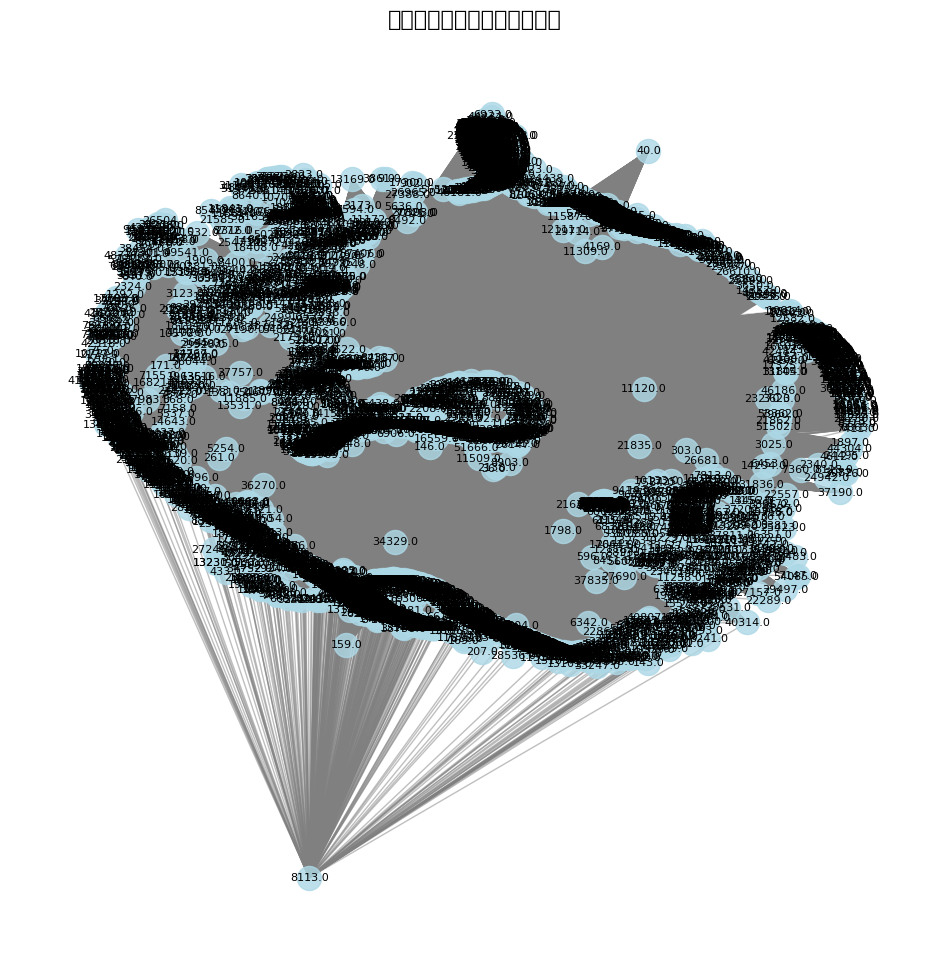

In [40]:
# 创建一个新图，仅包含概率高于阈值的边
predicted_graph = nx.Graph()
predicted_graph.add_edges_from(filtered_edges)

# 布局
pos = nx.spring_layout(predicted_graph, seed=42)

# 可视化
plt.figure(figsize=(12, 12))

# 绘制节点
nx.draw_networkx_nodes(predicted_graph, pos, node_size=300, node_color='lightblue', alpha=0.8)

# 绘制边
nx.draw_networkx_edges(predicted_graph, pos, edge_color='gray', alpha=0.5)

# 添加节点标签
nx.draw_networkx_labels(predicted_graph, pos, font_size=8, font_color='black')

# 图标题
plt.title("预测为可能成为好友的关系图", fontsize=16)
plt.axis('off')
plt.show()
